# Data Analysis - Irradiation of a Fibre Optic Sensor
Measuring humidity in radioactive environments is challenging because, as you might expect, the radiation is massively damaging to sensors. Most commercial humidity sensors are electronic and get wiped out by even a small dose of radiation. 
<!-- This presents a problem for measuring humidity in many environments with high radiation - in space, in nuclear industries and in high energy physics experiments. -->
<!-- (What commercial sensors?
How much radiation kills them??) -->

However, recently a new type of technology has emerged for these cases - fibre optic sensors (FOS). These can survive radiation doses up to the Mega-Gray (MGy) level while still giving a clear signal. Even better, the change in the signal itself can actually be used to measure the radiation dose. Combined with recent breakthroughs in FOS for measuring humidity, these sensors present an exciting potential product with applications in areas such as nuclear industry, high energy physics research, and space travel.
<!-- Link to FOS radiation studies
Link to LPG humidity studies
How much damage would MGy do to a person? -->

This project will take you through analysis of a sensor under irradiation, using real data recorded at the [PS-IRRAD facility](https://ps-irrad.web.cern.ch/ps-irrad/) in CERN, Geneva, SWitzerland.

Project on: [Github](https://github.com/rsamconn/Fibre-optics-demo/tree/notebook-analysis)

## EDA
- 4 datasets in `irrad-demo-data/`:
    - `spectra.txt` - a series of spectra, each containing 20,000 points
    - `times.txt` - A series of time values in seconds, starting at `06-SEP-2023 13.10.49`. Each value corresponds to a spectrum from `spectra.txt`
    - `hyperion-transmission-spectrum.txt` - a single spectrum of 20,000 points
    - `SEC_data_06-11_09_2023.csv` - data from the IRRAD facility recording the dose rate over time. We know that the maximum dose received by the sensors was 1.85 MGy

Let's take a look at the data

In [1]:
# Import the data
import pandas as pd
import numpy as np
# Load the data
data_dir = 'irrad-demo-data/'
spectra = np.loadtxt(data_dir + 'spectra.txt', delimiter=',')
times = np.loadtxt(data_dir + 'times.txt')
baseline = np.loadtxt(data_dir + 'hyperion-transmission-spectrum.txt')
irradiation_df = pd.read_csv(data_dir + 'SEC_data_06-11_09_2023.csv')

In [2]:
data_dict = {
    'spectra.txt': spectra,
    'times.txt': times,
    'hyperion-transmission-spectrum.txt': baseline,
    'SEC_data_06-11_09_2023.csv': irradiation_df
}
for file in data_dict.keys():
    print(f"{file} shape: {np.shape(data_dict[file])}")

spectra.txt shape: (48, 20000)
times.txt shape: (48,)
hyperion-transmission-spectrum.txt shape: (20000,)
SEC_data_06-11_09_2023.csv shape: (31039, 3)


So it looks like we have 48 time steps, and our irradiation data has 3 columns of over 31k rows. Let's look at the irradiation data first.

## 2. Radiation data

In [11]:
print("---------- First 5 rows of irradiation data: ----")
display(irradiation_df.head())
print("---------- Irradiation data value counts: -------")
display(irradiation_df.value_counts())
print("---------- Irradiation data info: ---------------")
display(irradiation_df.info())

---------- First 5 rows of irradiation data: ----


,SEC_ID,TIMESTAMP,SEC_counts
0,SEC_01,11-SEP-23 11.49.12,25376
1,SEC_01,11-SEP-23 11.49.01,25574
2,SEC_01,11-SEP-23 11.48.53,25340
3,SEC_01,11-SEP-23 11.48.48,25320
4,SEC_01,11-SEP-23 11.48.31,25269


---------- Irradiation data value counts: -------


SEC_ID  TIMESTAMP           SEC_counts
SEC_01  08-SEP-23 22.55.29  0             2
        10-SEP-23 14.13.47  0             2
        10-SEP-23 14.15.11  0             2
        06-SEP-23 22.34.30  26351         1
        10-SEP-23 04.07.34  25794         1
                                         ..
        08-SEP-23 15.25.41  26332         1
        08-SEP-23 15.25.29  26450         1
        08-SEP-23 15.25.12  26257         1
        08-SEP-23 15.25.00  26952         1
        11-SEP-23 11.49.12  25376         1
Name: count, Length: 31036, dtype: int64

---------- Irradiation data info: ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31039 entries, 0 to 31038
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SEC_ID      31039 non-null  object
 1   TIMESTAMP   31039 non-null  object
 2   SEC_counts  31039 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 727.6+ KB


None

Things to note:
- No empty cells.
- The SEC_ID only has 1 value - we can drop it.
- The TIMESTAMP column contains datetimes in *descending* order (we'll need to reverse that with `.iloc[::-1]`).
- The SEC_counts column has mostly unique integers - each is proportional to the radiation dose at that time.

Let's clean up the dataframe and add a column of the time elapsed in seconds so we can match it to our `times` data.

In [12]:
# Clean up the dataframe
# Reverse the order of the rows and drop the SEC_ID column
irradiation_df_clean = irradiation_df.iloc[::-1].reset_index(drop=True).drop(columns=['SEC_ID'])

# Create a datetime column
from datetime import datetime
convert_datetime = lambda x: datetime.strptime(x, "%d-%b-%y %H.%M.%S")
irradiation_df_clean['datetime'] = irradiation_df_clean['TIMESTAMP'].apply(convert_datetime)

# Create a column for the time elapsed in seconds
first_time = irradiation_df_clean['datetime'].iloc[0]
irradiation_df_clean['time_seconds'] = (irradiation_df_clean['datetime'] - first_time).dt.total_seconds()

# Show the first few rows with our new columns
print("DataFrame with new datetime columns:")
print(irradiation_df_clean.head())

DataFrame with new datetime columns:
            TIMESTAMP  SEC_counts            datetime  time_seconds
0  06-SEP-23 22.34.30       26351 2023-09-06 22:34:30           0.0
1  06-SEP-23 22.34.49       26087 2023-09-06 22:34:49          19.0
2  06-SEP-23 22.35.06       26412 2023-09-06 22:35:06          36.0
3  06-SEP-23 22.35.25       25872 2023-09-06 22:35:25          55.0
4  06-SEP-23 22.35.41       26543 2023-09-06 22:35:41          71.0


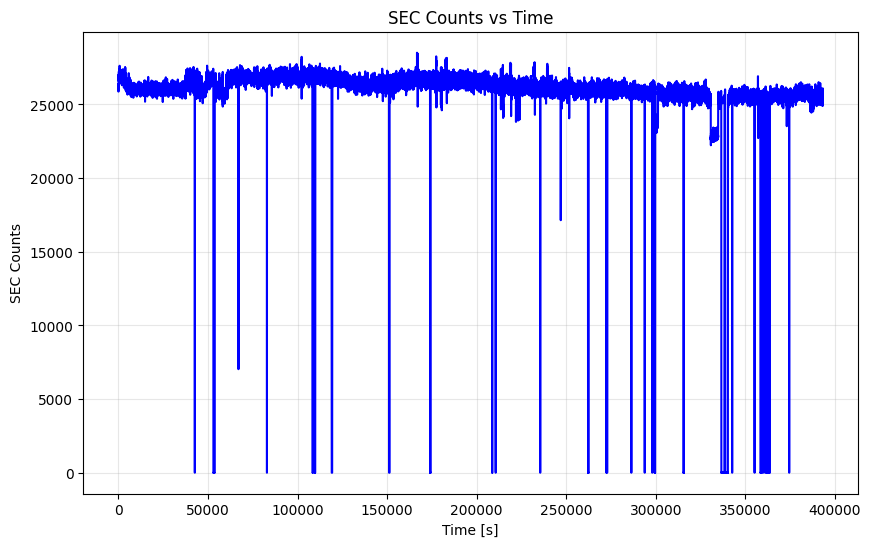

In [13]:
# Plot SEC_counts vs time
plt.figure(figsize=(10, 6))
plt.plot(irradiation_df_clean['time_seconds'], irradiation_df_clean['SEC_counts'], linestyle='-', color='blue')
plt.xlabel('Time [s]')
plt.ylabel('SEC Counts')
plt.title('SEC Counts vs Time')
plt.grid(True, alpha=0.3)
plt.show()

From this we can see the SEC_counts are mostly constant at around 25,000, occasionally dropping to 0 (presumably the proton beam was not always available.)

We know the absolute dose received by the sensor was 1.85 MGy - if we assume the total of the SEC_counts column is proportional to this value, we can calculate the dose over time.

In [16]:
# Calculate the total SEC_counts
total_SEC_counts = irradiation_df_clean['SEC_counts'].sum()

# Create a new column for the cumulative SEC_counts
irradiation_df_clean['cumulative_SEC_counts'] = irradiation_df_clean['SEC_counts'].cumsum()

# Create a new column for the cumulative SEC_counts as a proportion of the total SEC_counts
irradiation_df_clean['cumulative_SEC_counts_proportion'] = irradiation_df_clean['cumulative_SEC_counts'] / total_SEC_counts

irradiation_df_clean['dose_MGy'] = irradiation_df_clean['cumulative_SEC_counts_proportion'] * 1.85  # Assuming 1.85 MGy is the total dose

irradiation_df_clean.head()

,TIMESTAMP,SEC_counts,datetime,time_seconds,cumulative_SEC_counts,cumulative_SEC_counts_proportion,dose_MGy
0,06-SEP-23 22.34.30,26351,2023-09-06 22:34:30,0.0,26351,0.000033,0.000062
1,06-SEP-23 22.34.49,26087,2023-09-06 22:34:49,19.0,52438,0.000066,0.000123
2,06-SEP-23 22.35.06,26412,2023-09-06 22:35:06,36.0,78850,0.000100,0.000184
3,06-SEP-23 22.35.25,25872,2023-09-06 22:35:25,55.0,104722,0.000132,0.000245
4,06-SEP-23 22.35.41,26543,2023-09-06 22:35:41,71.0,131265,0.000166,0.000307


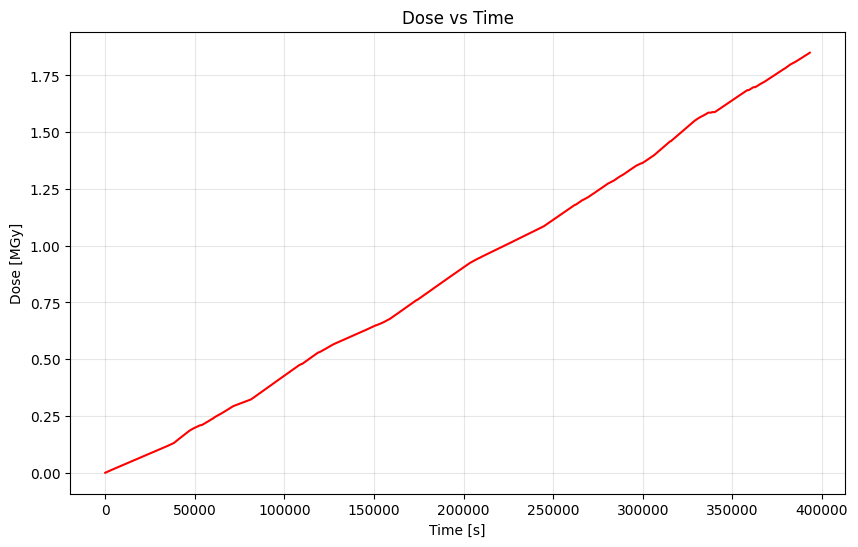

In [15]:
# Plot dose vs time
plt.figure(figsize=(10, 6))
plt.plot(irradiation_df_clean['time_seconds'], irradiation_df_clean['dose_MGy'], linestyle='-', color='red')
plt.xlabel('Time [s]')
plt.ylabel('Dose [MGy]')
plt.title('Dose vs Time')
plt.grid(True, alpha=0.3)
plt.show()

From this we see that the dose increases linearly with time, occasionally stopping when the beam is off.

Now let's take a look at the sensor data.

# 3. Spectra

First let's look at the time period the spectra data was taken over.

### 3.1 Time data



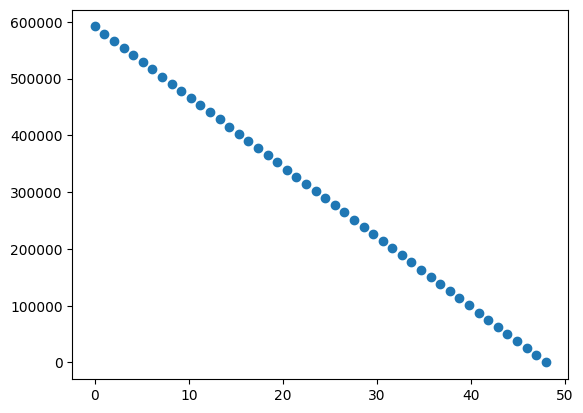

In [44]:
plt.scatter(np.linspace(0, len(times), len(times)), np.abs(times-times[-1]))
# plt.scatter(times, np.zeros_like(times))
plt.show()

So we have 48 points of time data spanning 600,000 s (12,500 s per step)

We know spectra were being recorded long before the irradiation started - were spectra also recorded after irradiation ended?

We want only the data recorded during irradiation.

In [45]:
# Convert the start time to a datetime object
spectra_start_time = datetime.strptime('06-SEP-2023 13.10.49', '%d-%b-%Y %H.%M.%S')
# Find the difference in seconds between spectra_start_time and the first irradiation time
first_irradiation_time = irradiation_df_clean['datetime'].iloc[0]
time_difference = (first_irradiation_time - spectra_start_time).total_seconds()
print(f"Time difference between first irradiation and spectra start time: {time_difference} seconds ({time_difference / 3600:.2f} hours)")

# Find the difference in seconds between the last spectra time and the last irradiation time
last_irradiation_time = irradiation_df_clean['datetime'].iloc[-1]
last_spectra_time = spectra_start_time + pd.to_timedelta(times[-1], unit='s')
last_time_difference = (last_spectra_time - last_irradiation_time).total_seconds()
print(f"Time difference between last irradiation and last spectra time: {last_time_difference} seconds ({last_time_difference / 3600:.2f} hours)")

Time difference between first irradiation and spectra start time: 33821.0 seconds (9.39 hours)
Time difference between last irradiation and last spectra time: 164853.958286 seconds (45.79 hours)


So spectra were being recorded for 9 hours before irradiation started and almost 2 days after as well.

This data can be cut.

In [46]:
# Find the times.txt point closest to the first irradiation time
closest_time_index = np.argmin(np.abs(times - time_difference))
closest_time = times[closest_time_index]
print(f"Closest time in times.txt to first irradiation time: {closest_time} seconds at index {closest_time_index}")

# Find the times.txt point closest to the last irradiation time
closest_last_time_index = np.argmin(np.abs(times - times[-1] + last_time_difference))
closest_last_time = times[closest_last_time_index]
print(f"Closest time in times.txt to last irradiation time: {closest_last_time} seconds at index {closest_last_time_index}")

Closest time in times.txt to first irradiation time: 37799.292143 seconds at index 3
Closest time in times.txt to last irradiation time: 428389.885266 seconds at index 34


So we can reduce our time and spectra data to just the steps 3-34.

In [47]:
# Cut the spectra and times data to only include the steps 3-34
start_index = 2  # Step 3 corresponds to index 2
end_index = 33   # Step 34 corresponds to index 33
spectra_cut = spectra[start_index:end_index + 1, :]
times_cut = times[start_index:end_index + 1]

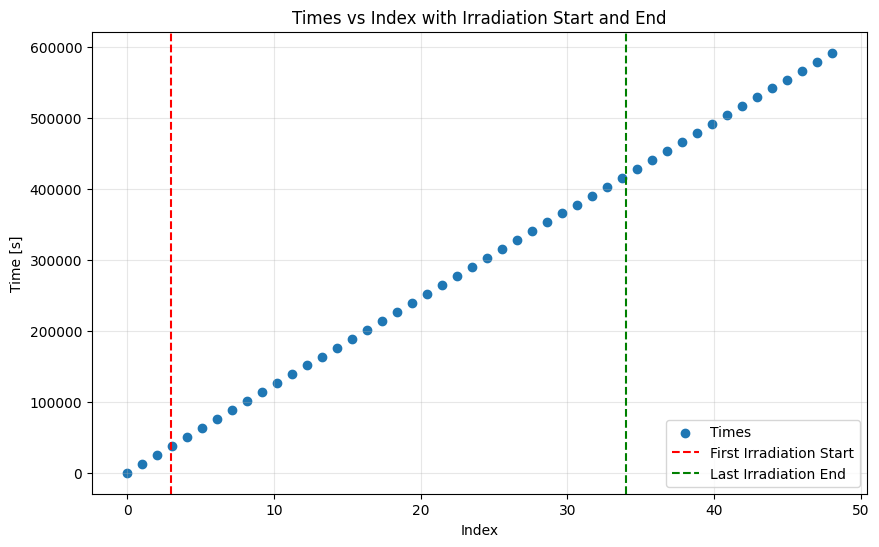

In [48]:
# Plot the times.txt data, showing where the irradiation started and ended
plt.figure(figsize=(10, 6))
plt.scatter(np.linspace(0, len(times), len(times)), times, label='Times')
plt.axvline(x=closest_time_index, color='red', linestyle='--', label='First Irradiation Start')
plt.axvline(x=closest_last_time_index, color='green', linestyle='--', label='Last Irradiation End')
plt.xlabel('Index')
plt.ylabel('Time [s]')
plt.title('Times vs Index with Irradiation Start and End')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 3.2 A single spectra
Next we'll look at just a single spectrum.

We'll need to use the wavelength range of the interrogator, the device that reads the spectra, which in our case is a [Hyperion si155](https://lunainc.com/sites/default/files/assets/files/data-sheets/HYPERION%20si155%20Data%20Sheet.pdf) (very expensive!). It has a range of *1460-1620 nm*.

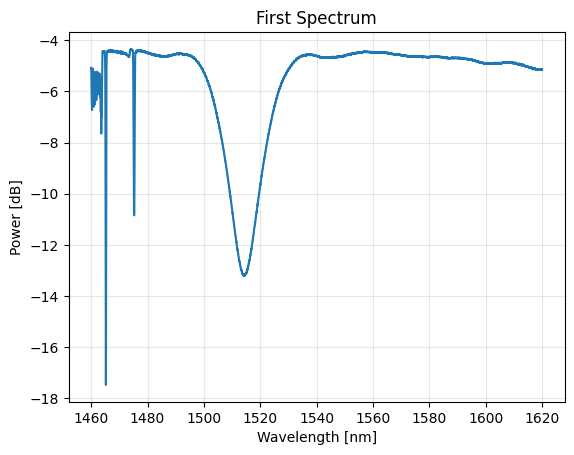

In [ ]:
# Create the wavelength range
wavelengths = np.linspace(1460, 1620, spectra.shape[1])

# Plot the first spectrum
import matplotlib.pyplot as plt
plt.plot(wavelengths, spectra[0])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Power [dB]')
plt.title('First Spectrum')
plt.grid(True, alpha=0.3)
plt.show()

We see the spectrum has 3 large dips - two between 1460-1480 nm and one around 1515 nm.
We're only interested in the latter, which corresponds to our LPG sensor.
Let's cut the uninteresting wavelengths out by saving versions of our data that only include wavelengths above 1480 nm.

In [53]:
# Find the index of the first wavelength above 1480 nm
wavelength_cutoff = np.where(wavelengths >= 1480)[0][0]

# Slice the spectra to only include wavelengths above 1480 nm
spectra_LPG_only = spectra_cut[:, wavelength_cutoff:]
wavelengths_LPG_only = wavelengths[wavelength_cutoff:]

Now we're ready to plot all the spectra.

## 3. Plot all the spectra

In [54]:
# Function to plot multiple spectra
import matplotlib.pyplot as plt
def plot_spectra(time_data, spectral_data, wavelength_data, start_idx, end_idx, time_step=30, title="Spectra", cmap='viridis'):
    """Plot wavelength vs intensity for each time point"""
    
    # Slice wavelength array
    wavelength_slice = wavelength_data[start_idx:end_idx]
    
    plt.figure(figsize=(10, 6))

    # If there's only one spectra, just plot normallly
    if type(time_data) is not np.ndarray:
        # If only one time point, plot it directly
        plt.plot(wavelength_slice, spectral_data[start_idx:end_idx], label=f'Time = {time_data:.3f}')
        plt.legend()
    # If there are multiple spectra, plot each with a different color
    else:
        # Set colormap
        colors = plt.cm.jet(np.linspace(0,1, len(time_data)))
        colors = plt.colormaps.get_cmap(cmap)(np.linspace(0, 1, len(time_data)))
        # Loop over each time point and plot
        for i in range(0, len(time_data), time_step):
            # print(f'Number of time steps {len(range(0, len(time_data), time_step))}')
            if len(range(0, len(time_data), time_step)) <= 20:
                # Use time values in legend if 15 or less
                plt.plot(wavelength_slice, spectral_data[i][start_idx:end_idx], color=colors[i], label=f'Time = {time_data[i]:.2f}')
            else:
                # No legend if more than 15 time points
                plt.plot(wavelength_slice, spectral_data[i][start_idx:end_idx], color=colors[i])
        
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Power [dB]')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

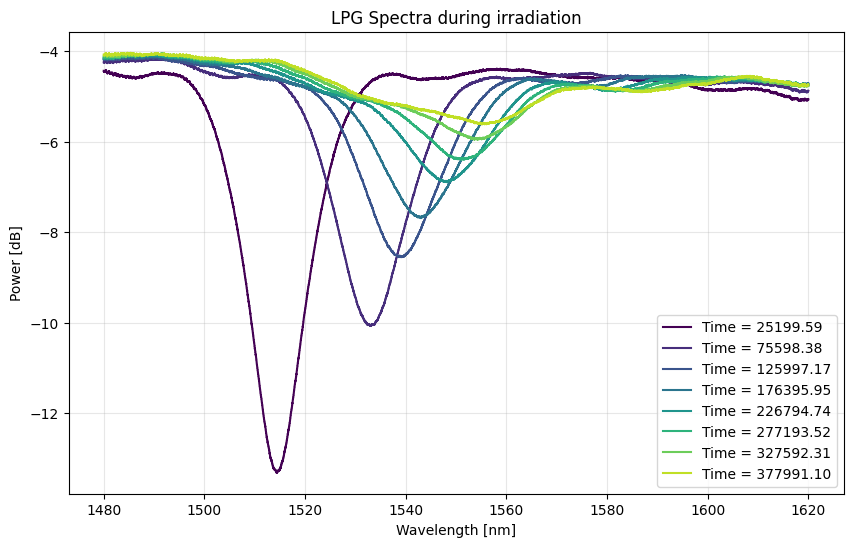

In [59]:
# Plot all the spectra
plot_spectra(times_cut, spectra_LPG_only, wavelengths_LPG_only, start_idx=0, end_idx=-1, time_step=4, title='LPG Spectra during irradiation')

That looks pretty and we can immediately see several effects on the spectrum as it gets irradiated:
- The dip is getting shallower - the power depth of the dip is decreasing.
- The dip moves to the right - the spectrum wavelength is redshifted as it gets irradiated.

However, it's a bit difficult to see the dip of the LPG spectra in the final time steps. Let's *rebaseline* the spectra - subtract the standard transmission spectrum that occurs when there's no sensor in the fibre.

In [7]:
# Subtract the baseline from the spectra
rebaselined_spectra = spectra_LPG_only - baseline[2500:]

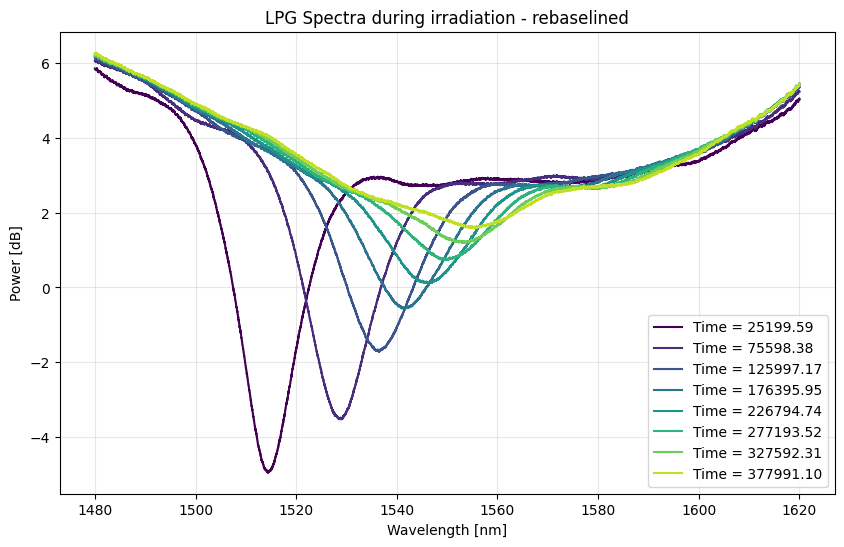

In [56]:
plot_spectra(times_cut, rebaselined_spectra, wavelengths_LPG_only, start_idx=0, end_idx=-1, time_step=4, title='LPG Spectra during irradiation - rebaselined')

That looks better - now we can see the LPG dip more clearly.

All very well but what can we do with this? The answer is in the last step - we track the redshift.

## 3. Wavelength Shift
Fibre optic sensors can measure changes in temperature, strain, relative humidity and much more because these shift the dip in their spectrum.

If we know how much the dip shifts, we can calibrate this to a reference and sensor and voila - we can measure that variable.

### 3.1 Extract the dip minima
There are many complex methods to tell how much a dip/ peak has shifted but we'll use a simple one here - extracting the minimum of the spectrum.

In [9]:
# Extract the spectra minima
def extract_spectra_minima(spectral_data, wavelength_data):
    """Extract the minima of each spectrum"""
    intensity_minima = []
    wavelength_minima = []
    count = 0
    for spectrum in spectral_data:
        count += 1
        min_index = np.argmin(spectrum)
        # print(f"Processing spectrum with shape {spectrum.shape} and found minimum at index {min_index} with wavelength {wavelength_data[min_index]}")
        intensity_minima.append(spectrum[min_index])
        wavelength_minima.append(wavelength_data[min_index])
    print(count)
    return wavelength_minima, intensity_minima

In [10]:
rebaselined_minima = extract_spectra_minima(rebaselined_spectra, wavelengths_LPG_only)


48


Text(0, 0.5, 'Wavelength shift [nm]')

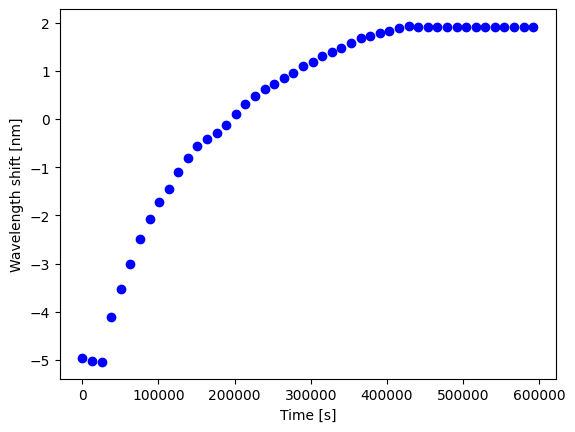

In [21]:
first_minimum = rebaselined_minima[0][0]
wavlength_shift = rebaselined_minima[0] - first_minimum
plt.scatter(times, rebaselined_minima[1], c='blue', label='Rebaselined Spectrum at Wavelength 1460 nm')
plt.xlabel('Time [s]')
plt.ylabel('Wavelength shift [nm]')

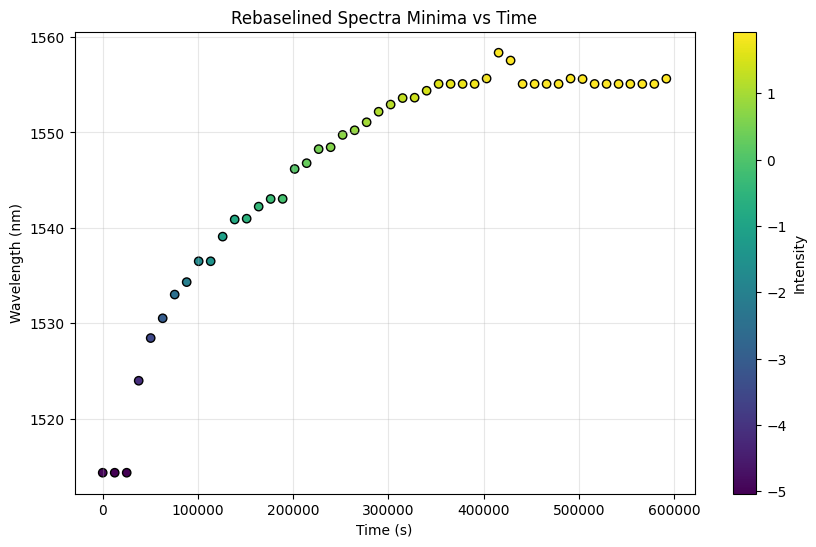

In [22]:
# Plot the minima vs time
def plot_minima_vs_time(minima, time_data, title="Spectra Minima vs Time"):
    """Plot the minima of each spectrum against time"""
    # wavelengths, intensities = zip(*minima)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(time_data, minima[0], c=minima[1], cmap='viridis', edgecolor='k')
    plt.colorbar(label='Intensity')
    plt.xlabel('Time (s)')
    plt.ylabel('Wavelength (nm)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()
plot_minima_vs_time(rebaselined_minima, times, title="Rebaselined Spectra Minima vs Time")

## 5. ?